In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.python.slim.nets.inception_v3 as inception_v3
import matplotlib.pyplot as plt
import time

In [2]:
def parser(record):
    img_features = tf.parse_single_example(
            record,
            features={ 'Label'    : tf.FixedLenFeature([], tf.int64),
                       'image_raw': tf.FixedLenFeature([], tf.string),
                       'height':tf.FixedLenFeature([],tf.int64),
                       'width':tf.FixedLenFeature([],tf.int64),
                       'channel':tf.FixedLenFeature([],tf.int64)})
    height = tf.cast(img_features['height'], tf.int64)
    width = tf.cast(img_features['width'], tf.int64)
    channel = tf.cast(img_features['channel'], tf.int64)
#     image_shape = tf.parallel_stack([height, width, channel])
    label = tf.cast(img_features['Label'], tf.int64)
    
    image = tf.decode_raw(img_features['image_raw'], tf.uint8)
    image = tf.reshape(image, [299,299,3])
#     image.set_shape([299,299,3])
    
    return image, label

In [3]:
def preprocess_for_train(image):
    image_data = tf.image.resize_images(image,[299,299],method=0)
    image_data = tf.image.random_saturation(image_data,lower=0.3,upper=1.3)
    image_data = tf.image.random_brightness(image_data,max_delta=60. /255.) #亮度
#     image_data = tf.image.random_contrast(image_data,0.5,1.5)
    image_data = tf.image.random_flip_left_right(image_data)
    return image_data

In [4]:
batch_size = 16
train_files = tf.train.match_filenames_once("./data/Train.tfrecords")
dataset = tf.data.TFRecordDataset(train_files)
dataset = dataset.map(parser)

test_files = tf.train.match_filenames_once("./data/Train.tfrecords")
test_dataset = tf.data.TFRecordDataset(test_files)
test_dataset = test_dataset.map(parser)

dataset = dataset.map(
    lambda image,label:(
        preprocess_for_train(image),label))
dataset = dataset.shuffle(2000).batch(batch_size)

test_dataset = test_dataset.map(
    lambda image,label:(
        tf.image.resize_images(image,[299,299],method=0),label))
test_dataset = test_dataset.batch(32)

In [5]:
def get_tuned_variable():
    exclusions = [scope.strip() for scope in CHECKPOINT_EXCLUDE_SCOPES.split(",")]
    variable_to_restore = []
#     slim.get_variables_to_restore()
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variable_to_restore.append(var)
    return variable_to_restore

def get_trainable_variable():
    scopes = [scope.strip() for scope in TRAINBLE_SCOPES.split(",")]
    variable_to_train = []
    for scope in scopes:
        variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope)
        variable_to_train.append(variables)
    return variable_to_train

In [6]:
NUM_EPOCH = 70
dataset = dataset.repeat(NUM_EPOCH)
Label_size = 830

iterator = dataset.make_initializable_iterator()
image_batch,label_batch = iterator.get_next()

test_iterator = test_dataset.make_initializable_iterator()
test_image_batch,test_label_batch = test_iterator.get_next()

learning_rate = 0.0001

In [7]:
CKPT_FILE = "inception_v3.ckpt"

CHECKPOINT_EXCLUDE_SCOPES = "InceptionV3/Logits,InceptionV3/AuxLogits"

TRAINBLE_SCOPES = "InceptionV3/Logits,InceptionV3/AuxLogits"

tf.reset_default_graph() 

initializer = tf.contrib.layers.xavier_initializer()
def weight_variable(shape):
    return tf.Variable(initializer(shape))

def bias_variable(shape):
    return tf.Variable(initializer(shape))

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

def max_pool(x):
    return tf.nn.max_pool(x,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

x = tf.placeholder(tf.float32,[None,299,299,3],name='input_x')
y = tf.placeholder(tf.int32,[None],name="input_y")
image_labels = tf.one_hot(y,Label_size)

with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    logits,_ = inception_v3.inception_v3(x,num_classes=Label_size)

logits = tf.identity(logits, name='logits')
trainable_variable = get_trainable_variable()


with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=image_labels,logits=logits))
    tf.summary.scalar('loss',loss)
with tf.name_scope('train'):
#     train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.name_scope('evaluation'):
    with tf.name_scope('correct_prediction'): 
        prediction = tf.argmax(logits,1,name="prediction")
        correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(image_labels,1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name='accuracy')
        tf.summary.scalar('accuracy',accuracy)
        
load_fn = slim.assign_from_checkpoint_fn(
    CKPT_FILE,
    get_tuned_variable(),
    ignore_missing_vars=True
)

tf.add_to_collection('pred_network', prediction)
merged = tf.summary.merge_all()

In [8]:
logs_dir = str(int(time.time()))
with tf.Session() as sess:
    load_fn(sess)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(iterator.initializer)
    save_model_path = 'logs/'+logs_dir+'/model/TransferModel.cpkt'
    train_writer = tf.summary.FileWriter('logs/'+logs_dir+'/train',sess.graph)
    test_writer = tf.summary.FileWriter('logs/'+logs_dir+'/test',sess.graph)
    
    count = 0
    train_t_acc = []
    train_t_loss = []
    test_t_acc = []
    test_t_loss = []
    train_acc = []
    train_loss = []
    while True:
        try:
            image,label = sess.run([image_batch,label_batch])
            _,train_acctemp,train_losstemp,summary = sess.run([train_step,accuracy,loss,merged], feed_dict={x: image, y: label})
            train_acc.append(train_acctemp)
            train_loss.append(train_losstemp)
            train_writer.add_summary(summary,count)
            if count % 100 == 0:
                sess.run(test_iterator.initializer)
                test_acc = []
                test_loss = []
                while True:
                    try:
                        test_image,test_label = sess.run([test_image_batch,test_label_batch])
                        test_acctemp,test_losstemp = sess.run([accuracy,loss],feed_dict={x: test_image,y:test_label})
                        test_acc.append(test_acctemp)
                        test_loss.append(test_losstemp)
                    except:
                        train_p_acc = np.mean(train_acc)
                        train_p_loss = np.mean(train_loss) 
                        test_p_acc = np.mean(test_acc)
                        test_p_loss = np.mean(test_loss)
                        test_summary = tf.Summary()
                        test_summary.value.add(tag="loss/loss", simple_value=test_p_loss)
                        test_summary.value.add(tag="evaluation/accuracy/accuracy",simple_value=test_p_acc)
                        test_writer.add_summary(test_summary,count)
                        print('Iter %d,train_acc %f train_loss %f test_acc %f test_loss %f' % (count,train_p_acc,train_p_loss,test_p_acc,test_p_loss))
                        train_t_acc.append(train_p_acc)
                        train_t_loss.append(train_p_loss)
                        test_t_acc.append(test_p_acc)
                        test_t_loss.append(test_p_loss)
                        train_acc = []
                        train_loss = []
                        break
            count+=1
        except :
            
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)
            print("Done")
            break

INFO:tensorflow:Restoring parameters from inception_v3.ckpt
Iter 0,train_acc 0.000000 train_loss 7.371699 test_acc 0.002287 test_loss 7.005661
Iter 100,train_acc 0.000000 train_loss 7.359416 test_acc 0.005335 test_loss 6.648420
Iter 200,train_acc 0.003125 train_loss 6.736683 test_acc 0.009146 test_loss 6.438189
Iter 300,train_acc 0.004375 train_loss 6.622713 test_acc 0.009146 test_loss 6.236151
Iter 400,train_acc 0.001250 train_loss 6.479763 test_acc 0.026677 test_loss 5.993959
Iter 500,train_acc 0.006250 train_loss 6.283617 test_acc 0.033883 test_loss 5.738375
Iter 600,train_acc 0.008750 train_loss 6.106936 test_acc 0.042614 test_loss 5.463283
Iter 700,train_acc 0.011875 train_loss 5.909225 test_acc 0.057511 test_loss 5.253594
Iter 800,train_acc 0.015625 train_loss 5.739325 test_acc 0.080308 test_loss 4.997653
Iter 900,train_acc 0.033125 train_loss 5.519934 test_acc 0.097492 test_loss 4.714389
Iter 1000,train_acc 0.036250 train_loss 5.246455 test_acc 0.109340 test_loss 4.533356
Iter 1

* LOSS 下降速度太慢(Learning rate 過小)，缺Training_acc,Training_loss，沒畫圖。 之後更新

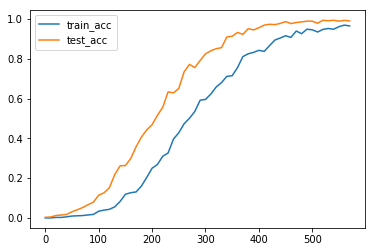

In [10]:
%matplotlib inline
x = np.arange(0, 58, 1)

 
plt.plot(x*10, train_t_acc, label="train_acc")
plt.plot(x*10, test_t_acc, label="test_acc")
 
plt.legend(loc=0, ncol=1) 
 
plt.show()

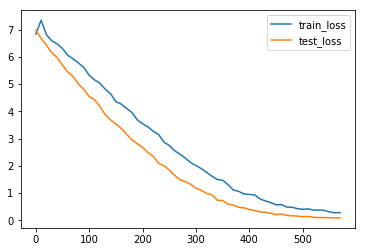

In [11]:
%matplotlib inline
x = np.arange(0, 58, 1)

 
plt.plot(x*10, train_t_loss, label="train_loss")
plt.plot(x*10, test_t_loss, label="test_loss")
 
plt.legend(loc=0, ncol=1) 
 
plt.show()